# Predicting The Ratings

## Table of Contents

* [Load Data](#Load-Data)
* [Functions](#Functions)
* [Model Function](#Model-Function)
* [PFI Function](#PFI)
* [Training and testing the models](#Training-and-testing-the-model)
* [Predict Fifa23 Data](#Predict-Fifa23-Data)
* [Results](#Results)
* [Feature Importance](#Feature-Importance)

In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBRegressor


Data Path 

In [2]:
folder = f"Dataset\After-PreProcess\predict-by-rating"

In [3]:
g_folder = f"Dataset\After-PreProcess\predict-with-real-life-stats"

## Load Data

In [4]:
## Ratings With Stats
g_fielders = pd.read_csv(g_folder+"/stats_Full_df.csv")
g_keepers = pd.read_csv(g_folder+"/stats_gk_df.csv")
g_defenders = pd.read_csv(g_folder+"/stats_defenders_df.csv")
stats_forward_df = pd.read_csv(g_folder+"/stats_forward_df.csv")
stats_midfielders_df = pd.read_csv(g_folder+"/stats_midfielders_df.csv")

In [5]:
## Fifa 23 Ratings With STATS 
g_stats_midfielders_df_f23 = pd.read_csv(g_folder+"/f23-stats_midfielders_df.csv")
g_stats_forward_df_f23 = pd.read_csv(g_folder+"/f23-stats_forward_df.csv")
g_defenders_f23 = pd.read_csv(g_folder+"/f23-stats_defenders_df.csv")

In [6]:
defenders_df23 = pd.read_csv(folder+"/f23-defenders_df.csv")
forward_df23 = pd.read_csv(folder+"/f23-forward_df.csv")
gk_df23 = pd.read_csv(folder+"/f23-gk_df.csv")
midfielders_df23 = pd.read_csv(folder+"/f23-midfielders_df.csv")


In [7]:
gk_df =pd.read_csv(folder+"/defenders_df.csv")
defenders_df=pd.read_csv(folder+"/defenders_df.csv")
midfielders_df=pd.read_csv(folder+"/defenders_df.csv")
forward_df= pd.read_csv(folder+"/defenders_df.csv")

## Functions

In [8]:
def drop_not_needed_fields(df , position_group):
    if position_group == "defenders":
        df = df.drop(['Unnamed: 0', 'Next_Year_Club','GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Best Position',  'Name' , 'Club', "Work Rate", "Positioning", "Position",
                     "Height", "Weight" , "Next_Year_Club"],axis = 1)
    elif position_group == "midfielders":
        df = df.drop(['Unnamed: 0', 'Next_Year_Club','GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Best Position',  'Name' , 'Club', "Work Rate", "Positioning", "Position",
                     "Height", "Weight" , "Next_Year_Club"],axis = 1)
    elif position_group == "forwards":
        df = df.drop(['Unnamed: 0', 'Next_Year_Club','GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Best Position',  'Name' , 'Club', "Work Rate", "Positioning", "Position",
                     "Height", "Weight" , "Next_Year_Club"],axis = 1)   
    elif  position_group == "goalkeepers":
        df = df.drop(['Unnamed: 0', 'Next_Year_Club', 'Best Position',  'Name' , 'Club', "Work Rate", "Positioning", "Position",
                     "Height", "Weight" , "Next_Year_Club",
                     'Crossing', 'Finishing','HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 'Agility', 'Reactions', 'Balance', 'ShotPower',
                       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
                       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
                       'StandingTackle', 'DefensiveAwareness'],axis = 1)
    return df

In [9]:
def split_df(df, test_size=0.25, random_state=42):
    """Splits a Pandas dataframe into train and test sets.

    Args:
    df: The Pandas dataframe to split.
    test_size: The size of the test set, as a fraction of the total dataset.
    random_state: The random state to use for shuffling the data.

    Returns:
    A tuple of train and test dataframes.
    """

    # Shuffle the data.
    df = df.sample(frac=1, random_state=random_state)

    # Split the data into train and test sets.
    train_size = int(len(df) * (1 - test_size))
    train_df = df[:train_size]
    test_df = df[train_size:]

    return train_df, test_df


In [10]:
def get_features(position_group):
    if position_group == "defenders":
        return ['Age', 'Overall', 'Potential' , 'Value', 'Wage',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'StandingTackle', 'SlidingTackle']
    elif position_group == "midfielders":
        return ['Age', 'Overall', 'Potential' , 'Value', 'Wage',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'StandingTackle', 'SlidingTackle']
    elif position_group == "forwards":
        return ['Age', 'Overall', 'Potential' , 'Value', 'Wage',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'StandingTackle', 'SlidingTackle']
    elif  position_group == "goalkeepers":
        return ['GKDiving', 'GKHandling','GKKicking', 'GKPositioning', 'GKReflexes','Age', 'Overall', 'Potential' , 'Value', 'Wage',
       'International Reputation', 'Acceleration','SprintSpeed']
        

In [11]:
# Direction functions
def analyze_movement_direction(df):
    same_count = 0
    higher_count = 0
    lower_count = 0

    for _, row in df.iterrows():
        next_overall = row['Next_Overall']
        prediction = row['predictions']

        if prediction > next_overall:
            higher_count += 1
        elif prediction < next_overall:
            lower_count += 1
        else:
            same_count += 1

    result = {
        'Predicted Right': same_count,
        'Predicted Higher': higher_count,
        'Predicted Lower': lower_count
    }

    return result


In [12]:
def analyze_movement(df):
    total_count = len(df)
    move_up_count = 0
    move_down_count = 0
    pred_move_up_count = 0
    pred_move_down_count = 0
    pred_same = 0
    same = 0
    for _, row in df.iterrows():
        overall = row['Overall']
        next_overall = row['Next_Overall']
        prediction = row['predictions']

        if next_overall > overall:
            move_up_count += 1
            if prediction > overall:
                pred_move_up_count += 1
        elif next_overall < overall:
            move_down_count += 1
            if prediction < overall:
                pred_move_down_count += 1
        else:
            same += 1
            if prediction == overall:
                pred_same += 1

    result = {
        'Total Rows': total_count,
        'Moved Up': move_up_count,
        'Predicted Move Up': pred_move_up_count,
        'Moved Down': move_down_count,
        'Predicted Move Down': pred_move_down_count,
        'Stayed the Same': same,
        'Predicted to Stay the Same': pred_same
    }

    return result


In [13]:
def generate_prediction_report(df):
    diff_counts = {'Exactly': 0,'Off by 1': 0, 'Off by 2': 0,'Off by 3': 0, 'Off by 4 or more': 0}

    for _, row in df.iterrows():
        next_overall = row['Next_Overall']
        prediction = row['predictions']
        diff = abs(next_overall - prediction)

        if diff == 1:
            diff_counts['Off by 1'] += 1
        elif diff == 2:
            diff_counts['Off by 2'] += 1
        elif diff == 3:
            diff_counts['Off by 3'] += 1
        elif diff >= 4:
            diff_counts['Off by 4 or more'] += 1
        else:
            diff_counts['Exactly'] += 1

    return diff_counts


In [14]:
def get_features_with_goals(position_group):
    if position_group == "defenders":
        return ['Age', 'Overall', 'Potential' , 'Value', 'Wage',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'StandingTackle', 'SlidingTackle', 'MP', 'Starts', 'Min', '90s',
       'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG',
       'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'Gls.1', 'Ast.1',
       'G+A.1', 'G-PK.1', 'G+A-PK', 'xG.1', 'xAG.1', 'xG+xAG', 'npxG.1',
       'npxG+xAG.1']
    elif position_group == "midfielders":
        return ['Age', 'Overall', 'Potential' , 'Value', 'Wage',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'StandingTackle', 'SlidingTackle', 'MP', 'Starts', 'Min', '90s',
       'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG',
       'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'Gls.1', 'Ast.1',
       'G+A.1', 'G-PK.1', 'G+A-PK', 'xG.1', 'xAG.1', 'xG+xAG', 'npxG.1',
       'npxG+xAG.1']
    elif position_group == "forwards":
        return ['Age', 'Overall', 'Potential' , 'Value', 'Wage',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'StandingTackle', 'SlidingTackle', 'MP', 'Starts', 'Min', '90s',
       'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG',
       'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'Gls.1', 'Ast.1',
       'G+A.1', 'G-PK.1', 'G+A-PK', 'xG.1', 'xAG.1', 'xG+xAG', 'npxG.1',
       'npxG+xAG.1']
    elif  position_group == "goalkeepers":
        return


In [15]:
import pandas as pd

def calculate_change(df, field1, field2, new_field):
    df[new_field] = pd.NA
    df.loc[df[field2] > df[field1], new_field] = "Improvement"
    df.loc[df[field2] == df[field1], new_field] = "Staying the same"
    df.loc[df[field2] < df[field1], new_field] = "Decline"
    return df


In [16]:
import matplotlib.pyplot as plt

def bar(dictionary):
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(dictionary)), list(dictionary.values()), align='center')
    plt.xticks(range(len(dictionary)), list(dictionary.keys()))
    plt.show()



In [17]:
def create_pie_chart(data_dict):
    keys = list(data_dict.keys())
    values = list(data_dict.values())

    plt.figure(figsize=(6, 6))
    plt.pie(values, labels=keys, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.show()


In [18]:
import matplotlib.pyplot as plt

def plot_bar_chart(dictionary , title):
    """
    Plots a bar chart with vertical labels from a dictionary.

    Args:
    dictionary: A dictionary where the keys are the labels and the values are the values for the bars.

    Returns:
    None.
    """
    # Get the labels and values from the dictionary.
    labels = list(dictionary.keys())
    values = list(dictionary.values())
    plt.figure(figsize=(12, 6))
    # Plot the bar chart.
    plt.bar(labels, values)

    # Set the labels to be vertical.
    plt.xticks(rotation=90)
    plt.title(title)

    # Show the plot.
    plt.show()


In [19]:
def calculate_delta(df, field1, field2, new_field):
    df[new_field] = defenderswithpredictions[field1]-defenderswithpredictions[field2]
    return df

In [20]:
import numpy as np

def calculate_average_delta(df):
    predictions = df['predictions']
    next_overall = df['Next_Overall']

    # Calculate the deltas
    deltas = np.abs(predictions - next_overall)

    # Calculate the average delta and standard deviation
    average_delta = np.mean(deltas)
    std_dev = np.std(deltas)

    return average_delta, std_dev

In [21]:
def accuracy_of_trend(df):
    df = calculate_change(df.copy() ,"Overall", "Next_Overall" , "real_trend")
    df = calculate_change(df.copy() ,"Overall", "predictions" , "predicted_trend")
    print("accuracy of trend: ", accuracy_score(df["real_trend"], df["predicted_trend"]))
    return df

In [75]:
def predict_new_data(model , new_data , features):
    
    imputer = SimpleImputer(strategy='mean')
    X_test = new_data[features].copy()
    X_test_imputed = imputer.fit_transform(X_test)
    y_pred = model.predict(X_test_imputed)
    # Add the predictions to the dataframe in a column
    new_data['Next_Overall'] = np.round(y_pred).astype(int)
    return new_data

In [23]:
column_mapping = {
    'Heading Accuracy':'HeadingAccuracy',
    'Sprint Speed':'SprintSpeed',
    'Known As': 'Name',
    'Positions Played': 'Position',
    'Image Link': 'ID',
    'Club Name': 'Club',
    'Club Position': 'Position',
    'Contract Until': 'Contract',
    'Club Jersey Number': 'Jersey Number',
    'Preferred Foot': 'Foot',
    'Weak Foot Rating': 'Weak Foot',
    'Shot Power':'ShotPower',
    'Long Shots':'LongShots',
    'Standing Tackle':'StandingTackle',
    'Sliding Tackle':'SlidingTackle',
    'Short Passing':'ShortPassing', 
    'Freekick Accuracy':'FKAccuracy', 
}


In [24]:
def rename_columns(df_f23, df_f22 , column_mapping):
    renamed_columns = []
    for column in df_f23.columns:
        if column in column_mapping:
            renamed_columns.append(column_mapping[column])
        else:
            renamed_columns.append(column)
    
    df_f23.columns = renamed_columns
    
    return df_f23


## Model Function

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer

from sklearn.inspection import permutation_importance


def run_model(df, features, model_type = "Random Forest"):   
    train_df, test_df = split_df(df)
    
    y_train = train_df['Next_Overall']
    y_test = test_df['Next_Overall']
    
    X_train = train_df[features].copy()
    X_test = test_df[features].copy()

    # Create a SimpleImputer to handle missing values
    imputer = KNNImputer()

    # Impute missing values in training data
    X_train_imputed = imputer.fit_transform(X_train)

    # Impute missing values in testing data
    X_test_imputed = imputer.transform(X_test)



    # Create the Random Forest Regression model
    if model_type.lower() == "xgboost":
        model = XGBRegressor()
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 5, 10]
        }
    else:   
        model = RandomForestRegressor(random_state=42)
            # Define the parameter grid for GridSearchCV
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10]
        }

    # Perform grid search to find the best model
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train_imputed, y_train)

    # Get the best model from grid search
    best_model = grid_search.best_estimator_
    best_model.fit(X_train_imputed, y_train)
    # Make predictions on the test set
    y_pred = np.round(best_model.predict(X_test_imputed))

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)

    # Compute permutation feature importance
    result = permutation_importance(best_model, X_train_imputed, y_train)
    feature_importance = {feature: importance for feature, importance in zip(features, result.importances_mean)}

    # Train the model with adjusted weights

    # Add the predictions to the dataframe in a column
    test_df['predictions'] = np.round(best_model.predict(X_test_imputed)).astype(int)
    test_df['Next_Overall'] = test_df['Next_Overall'].astype(int)
    print(f'Best Model Accuracy: {accuracy}')
    
    # Return the best model, test dataframe, feature importance, and best weight set
    return best_model, test_df, feature_importance


## PFI

In [41]:
import numpy as np
from sklearn.metrics import r2_score

def permutation_feature_importance(model, X, y, num_iterations=100):
    """
    Perform Permutation Feature Importance on a trained random forest model.

    Parameters:
        - model: Trained random forest model
        - X: Input features
        - y: Target variable
        - num_iterations: Number of iterations for permutation

    Returns:
        - feature_importances: Dictionary of feature importances
    """
    # Calculate the baseline score
    baseline_score = r2_score(y, model.predict(X))

    # Initialize an empty dictionary to store feature importances
    feature_importances = {}

    # Iterate over each feature
    for feature in X.columns:
        # Make a copy of the original feature values
        X_permuted = X.copy()

        # Permute the values of the current feature
        X_permuted[feature] = np.random.permutation(X_permuted[feature])

        # Calculate the score after permuting the feature
        permuted_score = r2_score(y, model.predict(X_permuted))

        # Calculate the feature importance as the difference between the baseline score and permuted score
        feature_importance = baseline_score - permuted_score

        # Store the feature importance in the dictionary
        feature_importances[feature] = feature_importance

    return feature_importances


## Model Report

In [27]:
def report_results(results_df):
    accuracy_of_trend(results_df.copy())
    average_delta ,std_dev = calculate_average_delta(results_df.copy())
    print("average delta of prediction from Next Overall: ",average_delta)
    print("standard deviation: ",std_dev)
    create_pie_chart(generate_prediction_report(results_df.copy()))

## Training and testing the model

Random Forest

In [28]:
model_def , defenderswithpredictions , def_pfi  = run_model(defenders_df.copy(), get_features("defenders"))

Best Model Accuracy: 0.2317773788150808


accuracy of trend:  0.44542190305206464
average delta of prediction from Next Overall:  1.4798922800718133
standard deviation:  1.4088874059651704


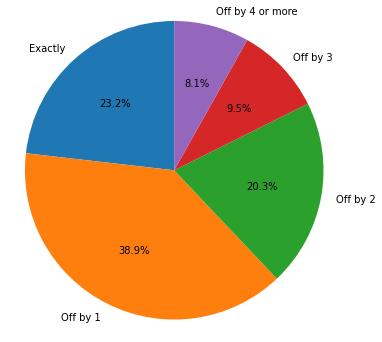

In [29]:
report_results(defenderswithpredictions)

In [30]:
model_mid, midsswithpredictions, mid_pfi  = run_model(midfielders_df.copy(), get_features("midfielders"))

Best Model Accuracy: 0.2317773788150808


accuracy of trend:  0.44542190305206464
average delta of prediction from Next Overall:  1.4798922800718133
standard deviation:  1.4088874059651704


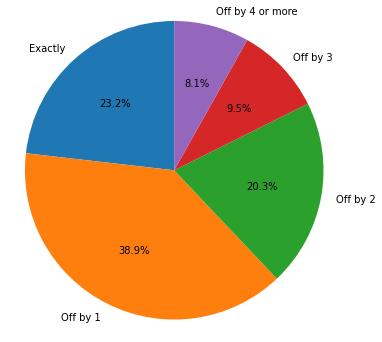

In [31]:
report_results(midsswithpredictions)

In [32]:
model_fw, fwwithpredictions, fwd_pfi = run_model(forward_df.copy() , get_features("forwards"))

Best Model Accuracy: 0.2317773788150808


accuracy of trend:  0.44542190305206464
average delta of prediction from Next Overall:  1.4798922800718133
standard deviation:  1.4088874059651704


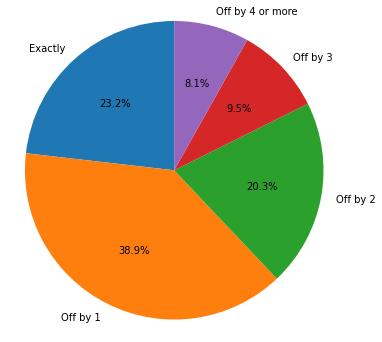

In [33]:
report_results(fwwithpredictions)

XGBoost

In [44]:
xgmodel_def , xgdefenderswithpredictions , xgdef_pfi  = run_model(defenders_df.copy(), get_features("defenders"), model_type ="xgboost")

Best Model Accuracy: 0.23087971274685817


accuracy of trend:  0.4488330341113106
average delta of prediction from Next Overall:  1.5136445242369838
standard deviation:  1.4430831132826647


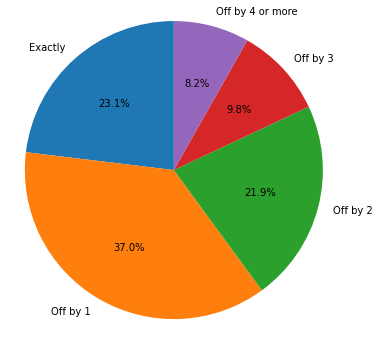

In [45]:
report_results(xgdefenderswithpredictions)

In [46]:
xgmodel_mid, xgmidsswithpredictions, xgmid_pfi  = run_model(midfielders_df.copy(), get_features("midfielders"), model_type ="xgboost")

Best Model Accuracy: 0.23087971274685817


accuracy of trend:  0.4488330341113106
average delta of prediction from Next Overall:  1.5136445242369838
standard deviation:  1.4430831132826647


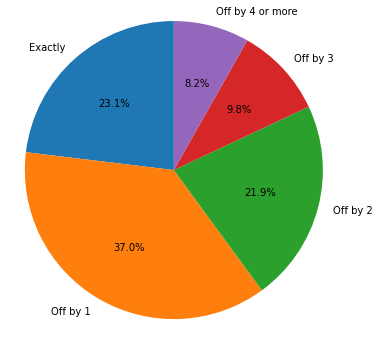

In [47]:
report_results(xgmidsswithpredictions)

In [48]:
xgmodel_fw, xgfwwithpredictions, xgfwd_pfi = run_model(forward_df.copy() , get_features("forwards"), model_type ="xgboost")

Best Model Accuracy: 0.23087971274685817


accuracy of trend:  0.4488330341113106
average delta of prediction from Next Overall:  1.5136445242369838
standard deviation:  1.4430831132826647


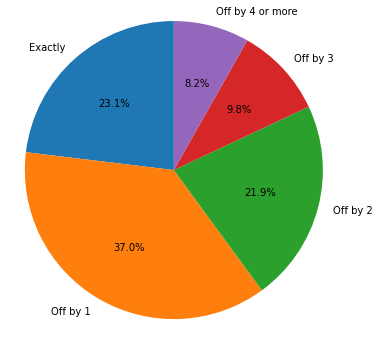

In [49]:
report_results(xgfwwithpredictions)

## With Stats

Random Forest

In [56]:
model_defenders_g , defenderswithpredictions_g , def_pfi_g  = run_model(g_defenders.copy(), get_features_with_goals("defenders"))

Best Model Accuracy: 0.26596858638743454


accuracy of trend:  0.5099476439790576
average delta of prediction from Next Overall:  1.3350785340314135
standard deviation:  1.3195171531255725


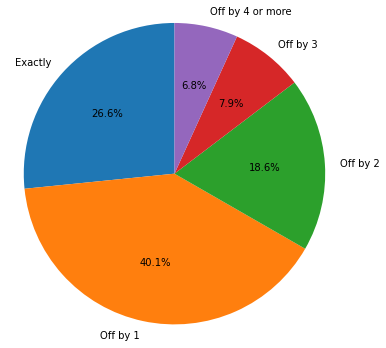

In [57]:
report_results(defenderswithpredictions_g)

In [58]:
model_mids_g , midswithpredictions_g, mid_pfi_g  = run_model(stats_midfielders_df.copy(), get_features_with_goals("defenders"))

Best Model Accuracy: 0.30422794117647056


accuracy of trend:  0.5119485294117647
average delta of prediction from Next Overall:  1.228860294117647
standard deviation:  1.2134410336917762


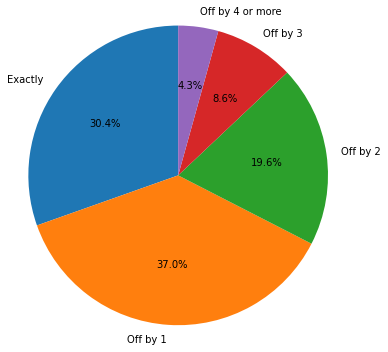

In [59]:
report_results(midswithpredictions_g)

In [60]:
model_forwards_g , forwardswithpredictions_g, fw_pfi_g  = run_model(stats_forward_df.copy(), get_features_with_goals("defenders"))

Best Model Accuracy: 0.2953271028037383


accuracy of trend:  0.5401869158878505
average delta of prediction from Next Overall:  1.2149532710280373
standard deviation:  1.2606780358068899


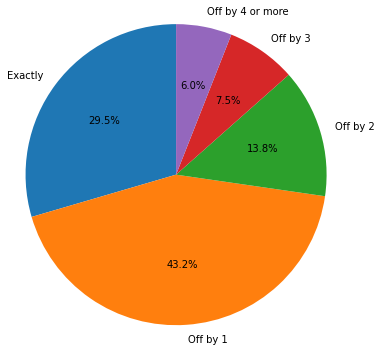

In [61]:
report_results(forwardswithpredictions_g)

XGBoost

In [50]:
xgmodel_defenders_g , xgdefenderswithpredictions_g , xgdef_pfi_g  = run_model(g_defenders.copy(), get_features_with_goals("defenders"),model_type ="xgboost")

Best Model Accuracy: 0.27225130890052357


accuracy of trend:  0.5319371727748691
average delta of prediction from Next Overall:  1.4041884816753927
standard deviation:  1.3567682753353074


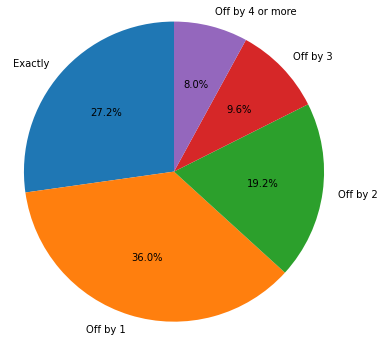

In [51]:
report_results(xgdefenderswithpredictions_g)

In [52]:
xgmodel_mids_g , xgmidswithpredictions_g, xgmid_pfi_g  = run_model(stats_midfielders_df.copy(), get_features_with_goals("defenders"),model_type ="xgboost")

Best Model Accuracy: 0.25735294117647056


accuracy of trend:  0.5202205882352942
average delta of prediction from Next Overall:  1.3134191176470589
standard deviation:  1.2232896526744494


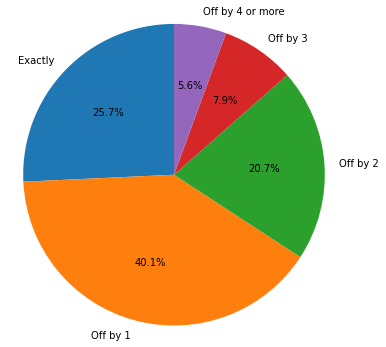

In [53]:
report_results(xgmidswithpredictions_g)

In [54]:
xgmodel_forwards_g , xgforwardswithpredictions_g, xgfw_pfi_g  = run_model(stats_forward_df.copy(), get_features_with_goals("defenders"),model_type ="xgboost")

Best Model Accuracy: 0.2616822429906542


accuracy of trend:  0.4934579439252336
average delta of prediction from Next Overall:  1.388785046728972
standard deviation:  1.3569707262597612


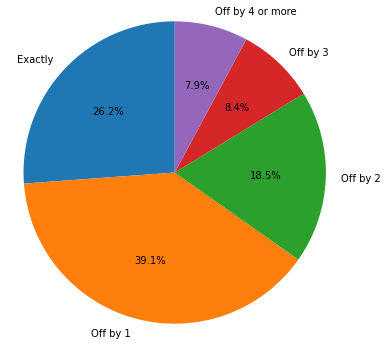

In [55]:
report_results(xgforwardswithpredictions_g)

### Predict Fifa23 Data

In [62]:
defenders_df23 = rename_columns(defenders_df23 , defenders_df , column_mapping)

In [63]:
midfielders_df23 = rename_columns(midfielders_df23 , midfielders_df , column_mapping)

In [64]:
forward_df23 = rename_columns(forward_df23 , forward_df , column_mapping)

In [76]:
g_stats_midfielders_df_f23 = rename_columns(g_stats_midfielders_df_f23 , midfielders_df , column_mapping)
g_stats_forward_df_f23 = rename_columns(g_stats_forward_df_f23 , forward_df , column_mapping)
g_defenders_f23 = rename_columns(g_defenders_f23 , defenders_df , column_mapping)

Predicted fifa 23 data

In [66]:
predicted_df_def = predict_new_data(model_def , defenders_df23.copy() , get_features("defenders"))

In [67]:
predicted_df_mid = predict_new_data(model_mid , midfielders_df23.copy()  , get_features("midfielders"))

In [68]:
predicted_df_fw = predict_new_data(model_fw , forward_df23.copy() , get_features("forwards"))

XGBoost

In [69]:
xgpredicted_df_def = predict_new_data(xgmodel_def , defenders_df23.copy() , get_features("defenders"))

In [70]:
xgpredicted_df_mid = predict_new_data(xgmodel_mid , midfielders_df23.copy()  , get_features("midfielders"))

In [71]:
xgpredicted_df_fw = predict_new_data(xgmodel_fw , forward_df23.copy() , get_features("forwards"))

With goals

In [72]:
predicted_df_def_g = predict_new_data(model_defenders_g , g_defenders_f23.copy() , get_features_with_goals("defenders"))

In [80]:
predicted_df_mid_g = predict_new_data(model_mids_g , g_stats_midfielders_df_f23.copy() , get_features_with_goals("midfielders"))

In [81]:
predicted_df_fw_g = predict_new_data(model_forwards_g , g_stats_forward_df_f23.copy() , get_features_with_goals("forwards"))

XGBoost

In [82]:
xgpredicted_df_def_g = predict_new_data(xgmodel_defenders_g , g_defenders_f23.copy() , get_features_with_goals("defenders"))

In [83]:
xgpredicted_df_mid_g = predict_new_data(xgmodel_mids_g , g_stats_midfielders_df_f23.copy() , get_features_with_goals("midfielders"))

In [84]:
xgpredicted_df_fw_g = predict_new_data(xgmodel_forwards_g , g_stats_forward_df_f23.copy() , get_features_with_goals("forwards"))

## Results

In [85]:
predicted_df_def[["Name","ID","Overall","Next_Overall"]].head(10)

Name                                                ID  Overall  \
0   V. van Dijk  https://cdn.sofifa.net/players/203/376/23_60.png       90   
1    Rúben Dias  https://cdn.sofifa.net/players/239/818/23_60.png       88   
2  João Cancelo  https://cdn.sofifa.net/players/210/514/23_60.png       88   
3    Marquinhos  https://cdn.sofifa.net/players/207/865/23_60.png       88   
4    A. Rüdiger  https://cdn.sofifa.net/players/205/452/23_60.png       87   
5  A. Robertson  https://cdn.sofifa.net/players/216/267/23_60.png       87   
6  K. Koulibaly  https://cdn.sofifa.net/players/201/024/23_60.png       87   
7      D. Alaba  https://cdn.sofifa.net/players/197/445/23_60.png       86   
8  Thiago Silva  https://cdn.sofifa.net/players/164/240/23_60.png       86   
9    A. Laporte  https://cdn.sofifa.net/players/212/218/23_60.png       86   

   Next_Overall  
0            89  
1            88  
2            87  
3            88  
4            86  
5            87  
6            86  
7            86  
8            85  
9            86

In [86]:
predicted_df_def_g[["Name","ID","Overall","predictions","Next_Overall"]].head(20)

KeyError: "['predictions'] not in index"

In [88]:
predicted_df_mid[["Name","ID","Overall","Next_Overall"]].head(20)

Name                                                ID  \
0              L. Messi  https://cdn.sofifa.net/players/158/023/23_60.png   
1          K. De Bruyne  https://cdn.sofifa.net/players/192/985/23_60.png   
2              Casemiro  https://cdn.sofifa.net/players/200/145/23_60.png   
3               S. Mané  https://cdn.sofifa.net/players/208/722/23_60.png   
4            J. Kimmich  https://cdn.sofifa.net/players/212/622/23_60.png   
5              N. Kanté  https://cdn.sofifa.net/players/215/914/23_60.png   
6        Bernardo Silva  https://cdn.sofifa.net/players/218/667/23_60.png   
7              T. Kroos  https://cdn.sofifa.net/players/182/521/23_60.png   
8             L. Modrić  https://cdn.sofifa.net/players/177/003/23_60.png   
9                 Rodri  https://cdn.sofifa.net/players/231/866/23_60.png   
10              Fabinho  https://cdn.sofifa.net/players/209/499/23_60.png   
11            T. Müller  https://cdn.sofifa.net/players/189/596/23_60.png   
12          M. Verratti  https://cdn.sofifa.net/players/199/556/23_60.png   
13  T. Alexander-Arnold  https://cdn.sofifa.net/players/231/281/23_60.png   
14          L. Goretzka  https://cdn.sofifa.net/players/209/658/23_60.png   
15           F. de Jong  https://cdn.sofifa.net/players/228/702/23_60.png   
16               Thiago  https://cdn.sofifa.net/players/189/509/23_60.png   
17            P. Dybala  https://cdn.sofifa.net/players/211/110/23_60.png   
18      Bruno Fernandes  https://cdn.sofifa.net/players/212/198/23_60.png   
19               Parejo  https://cdn.sofifa.net/players/189/513/23_60.png   

    Overall  Next_Overall  
0        91            87  
1        91            88  
2        89            88  
3        89            88  
4        89            88  
5        89            88  
6        88            87  
7        88            87  
8        88            86  
9        87            86  
10       87            87  
11       87            86  
12       87            86  
13       87            87  
14       87            86  
15       87            86  
16       86            86  
17       86            86  
18       86            86  
19       86            86

In [90]:
predicted_df_mid_g[["Name","ID","Overall","Next_Overall"]].head(10)

Name      ID  Overall  Next_Overall
0   R. Nainggolan  178518       86            85
1        P. Pogba  195864       88            88
2        A. Vidal  181872       86            85
3    K. De Bruyne  192985       91            90
4       L. Modrić  177003       89            89
5     L. Goretzka  209658       83            82
6          Marlos  187754       82            82
7         Morales  216475       79            80
8        Mosquera  178625       75            75
9         Montoro  186682       71            71

In [91]:
predicted_df_fw[["Name","ID","Overall","Next_Overall"]].head(20)

Name                                                ID  \
0          K. Benzema  https://cdn.sofifa.net/players/165/153/23_60.png   
1      R. Lewandowski  https://cdn.sofifa.net/players/188/545/23_60.png   
2           K. Mbappé  https://cdn.sofifa.net/players/231/747/23_60.png   
3            M. Salah  https://cdn.sofifa.net/players/209/331/23_60.png   
4   Cristiano Ronaldo  https://cdn.sofifa.net/players/020/801/23_60.png   
5             H. Kane  https://cdn.sofifa.net/players/202/126/23_60.png   
6           Neymar Jr  https://cdn.sofifa.net/players/190/871/23_60.png   
7              H. Son  https://cdn.sofifa.net/players/200/104/23_60.png   
8          E. Haaland  https://cdn.sofifa.net/players/239/085/23_60.png   
9         C. Immobile  https://cdn.sofifa.net/players/192/387/23_60.png   
10          R. Lukaku  https://cdn.sofifa.net/players/192/505/23_60.png   
11        R. Sterling  https://cdn.sofifa.net/players/202/652/23_60.png   
12          R. Mahrez  https://cdn.sofifa.net/players/204/485/23_60.png   
13        L. Martínez  https://cdn.sofifa.net/players/231/478/23_60.png   
14       Vinícius Jr.  https://cdn.sofifa.net/players/238/794/23_60.png   
15      P. Aubameyang  https://cdn.sofifa.net/players/188/567/23_60.png   
16         Iago Aspas  https://cdn.sofifa.net/players/192/629/23_60.png   
17           M. Depay  https://cdn.sofifa.net/players/202/556/23_60.png   
18      Gerard Moreno  https://cdn.sofifa.net/players/208/093/23_60.png   
19           J. Vardy  https://cdn.sofifa.net/players/208/830/23_60.png   

    Overall  Next_Overall  
0        91            88  
1        91            88  
2        91            88  
3        90            88  
4        90            88  
5        89            88  
6        89            88  
7        89            88  
8        88            87  
9        86            85  
10       86            86  
11       86            86  
12       86            86  
13       86            86  
14       86            86  
15       85            84  
16       85            84  
17       85            84  
18       85            84  
19       85            84

In [92]:
predicted_df_fw_g[["Name","ID","Overall","Next_Overall"]].head(20)

Name      ID  Overall  Next_Overall
0            L. Suárez  176580       92            91
1          A. Florenzi  203551       82            81
2    Cristiano Ronaldo   20801       94            93
3           A. Sánchez  184941       88            84
4           A. Sánchez  184941       88            85
5      Roberto Firmino  201942       85            85
6              Crislan  224126       70            70
7              Crislan  224126       70            69
8         A. Griezmann  194765       88            86
9       R. Lewandowski  188545       91            90
10            Jonathas  189169       78            76
11            Jonathas  189169       78            76
12            M. Salah  209331       87            89
13             D. Alli  211117       84            85
14            Adaílton  190139       67            68
15           E. Cavani  179813       88            89
16                Mata  223578       75            74
17                Mata  223578       75            74
18        M. Mandžukić  181783       83            84
19             Rodrigo  198329       81            80

XGBoost

In [93]:
xgpredicted_df_def[["Name","ID","Overall","Next_Overall"]].head()

Name                                                ID  Overall  \
0   V. van Dijk  https://cdn.sofifa.net/players/203/376/23_60.png       90   
1    Rúben Dias  https://cdn.sofifa.net/players/239/818/23_60.png       88   
2  João Cancelo  https://cdn.sofifa.net/players/210/514/23_60.png       88   
3    Marquinhos  https://cdn.sofifa.net/players/207/865/23_60.png       88   
4    A. Rüdiger  https://cdn.sofifa.net/players/205/452/23_60.png       87   

   Next_Overall  
0            91  
1            88  
2            88  
3            89  
4            87

In [95]:
xgpredicted_df_def_g[["Name","ID","Overall","Next_Overall"]].head(20)

Name      ID  Overall  Next_Overall
0         D. Alaba  197445       85            84
1       Jordi Alba  189332       87            86
2       A. Kolarov  185103       81            83
3          Marcelo  176676       87            86
4      Alex Sandro  191043       86            86
5          Fábinho  188522       66            64
6           Felipe     768       75            74
7      A. Valencia  167905       83            78
8        L. Baines  163631       80            76
9     R. Rodríguez  193352       80            80
10       K. Walker  188377       84            84
11      J. Kimmich  212622       84            85
12      K. Asamoah  186832       79            79
13   Marcos Alonso  192638       82            82
14          Cédric  201118       78            78
15          Cédric  201118       78            77
16            Capa  216189       78            80
17            Capa  216189       78            78
18        Carvajal  204963       84            85
19        Carvajal  204963       84            83

In [96]:
xgpredicted_df_mid[["Name","ID","Overall","Next_Overall"]].head(20)

Name                                                ID  \
0              L. Messi  https://cdn.sofifa.net/players/158/023/23_60.png   
1          K. De Bruyne  https://cdn.sofifa.net/players/192/985/23_60.png   
2              Casemiro  https://cdn.sofifa.net/players/200/145/23_60.png   
3               S. Mané  https://cdn.sofifa.net/players/208/722/23_60.png   
4            J. Kimmich  https://cdn.sofifa.net/players/212/622/23_60.png   
5              N. Kanté  https://cdn.sofifa.net/players/215/914/23_60.png   
6        Bernardo Silva  https://cdn.sofifa.net/players/218/667/23_60.png   
7              T. Kroos  https://cdn.sofifa.net/players/182/521/23_60.png   
8             L. Modrić  https://cdn.sofifa.net/players/177/003/23_60.png   
9                 Rodri  https://cdn.sofifa.net/players/231/866/23_60.png   
10              Fabinho  https://cdn.sofifa.net/players/209/499/23_60.png   
11            T. Müller  https://cdn.sofifa.net/players/189/596/23_60.png   
12          M. Verratti  https://cdn.sofifa.net/players/199/556/23_60.png   
13  T. Alexander-Arnold  https://cdn.sofifa.net/players/231/281/23_60.png   
14          L. Goretzka  https://cdn.sofifa.net/players/209/658/23_60.png   
15           F. de Jong  https://cdn.sofifa.net/players/228/702/23_60.png   
16               Thiago  https://cdn.sofifa.net/players/189/509/23_60.png   
17            P. Dybala  https://cdn.sofifa.net/players/211/110/23_60.png   
18      Bruno Fernandes  https://cdn.sofifa.net/players/212/198/23_60.png   
19               Parejo  https://cdn.sofifa.net/players/189/513/23_60.png   

    Overall  Next_Overall  
0        91            89  
1        91            85  
2        89            87  
3        89            91  
4        89            88  
5        89            87  
6        88            88  
7        88            85  
8        88            84  
9        87            87  
10       87            87  
11       87            86  
12       87            85  
13       87            87  
14       87            86  
15       87            86  
16       86            85  
17       86            89  
18       86            83  
19       86            81

In [97]:
xgpredicted_df_mid_g[["Name","ID","Overall","Next_Overall"]].head(30)

Name      ID  Overall  Next_Overall
0     R. Nainggolan  178518       86            85
1          P. Pogba  195864       88            88
2          A. Vidal  181872       86            85
3      K. De Bruyne  192985       91            91
4         L. Modrić  177003       89            88
5       L. Goretzka  209658       83            84
6            Marlos  187754       82            82
7           Morales  216475       79            81
8          Mosquera  178625       75            75
9           Montoro  186682       71            71
10            Magno  192259       69            70
11    Ander Herrera  191740       83            81
12   G. Bonaventura  189125       82            82
13       C. Tolisso  219683       82            83
14      Fernandinho  135507       85            87
15       B. Matuidi  170890       85            85
16       B. Matuidi  170890       85            85
17     Z. Junuzović  173474       79            77
18    João Moutinho  162347       82            83
19        M. Pjanić  180206       86            86
20         T. Kroos  182521       90            89
21           Thiago  189509       88            87
22          Tyronne  198964       69            67
23       K. Boateng  173909       81            80
24        M. Sanson  210896       81            80
25        K. Walker  183885       67            64
26         T. Lemar  213565       83            83
27     R. Guerreiro  209889       80            79
28     J. Henderson  183711       81            82
29     G. Wijnaldum  181291       82            82

In [98]:
xgpredicted_df_fw[["Name","ID","Overall","Next_Overall"]].head(20)

Name                                                ID  \
0          K. Benzema  https://cdn.sofifa.net/players/165/153/23_60.png   
1      R. Lewandowski  https://cdn.sofifa.net/players/188/545/23_60.png   
2           K. Mbappé  https://cdn.sofifa.net/players/231/747/23_60.png   
3            M. Salah  https://cdn.sofifa.net/players/209/331/23_60.png   
4   Cristiano Ronaldo  https://cdn.sofifa.net/players/020/801/23_60.png   
5             H. Kane  https://cdn.sofifa.net/players/202/126/23_60.png   
6           Neymar Jr  https://cdn.sofifa.net/players/190/871/23_60.png   
7              H. Son  https://cdn.sofifa.net/players/200/104/23_60.png   
8          E. Haaland  https://cdn.sofifa.net/players/239/085/23_60.png   
9         C. Immobile  https://cdn.sofifa.net/players/192/387/23_60.png   
10          R. Lukaku  https://cdn.sofifa.net/players/192/505/23_60.png   
11        R. Sterling  https://cdn.sofifa.net/players/202/652/23_60.png   
12          R. Mahrez  https://cdn.sofifa.net/players/204/485/23_60.png   
13        L. Martínez  https://cdn.sofifa.net/players/231/478/23_60.png   
14       Vinícius Jr.  https://cdn.sofifa.net/players/238/794/23_60.png   
15      P. Aubameyang  https://cdn.sofifa.net/players/188/567/23_60.png   
16         Iago Aspas  https://cdn.sofifa.net/players/192/629/23_60.png   
17           M. Depay  https://cdn.sofifa.net/players/202/556/23_60.png   
18      Gerard Moreno  https://cdn.sofifa.net/players/208/093/23_60.png   
19           J. Vardy  https://cdn.sofifa.net/players/208/830/23_60.png   

    Overall  Next_Overall  
0        91            92  
1        91            90  
2        91            92  
3        90            88  
4        90            91  
5        89            90  
6        89            90  
7        89            91  
8        88            90  
9        86            91  
10       86            91  
11       86            88  
12       86            89  
13       86            91  
14       86            92  
15       85            89  
16       85            88  
17       85            90  
18       85            90  
19       85            87

In [100]:
xgpredicted_df_fw_g[["Name","ID","Overall","Next_Overall"]].head(20)

Name      ID  Overall  Next_Overall
0            L. Suárez  176580       92            91
1          A. Florenzi  203551       82            80
2    Cristiano Ronaldo   20801       94            94
3           A. Sánchez  184941       88            83
4           A. Sánchez  184941       88            84
5      Roberto Firmino  201942       85            86
6              Crislan  224126       70            69
7              Crislan  224126       70            69
8         A. Griezmann  194765       88            87
9       R. Lewandowski  188545       91            90
10            Jonathas  189169       78            76
11            Jonathas  189169       78            76
12            M. Salah  209331       87            89
13             D. Alli  211117       84            85
14            Adaílton  190139       67            67
15           E. Cavani  179813       88            89
16                Mata  223578       75            74
17                Mata  223578       75            75
18        M. Mandžukić  181783       83            85
19             Rodrigo  198329       81            80

## Feature Importance

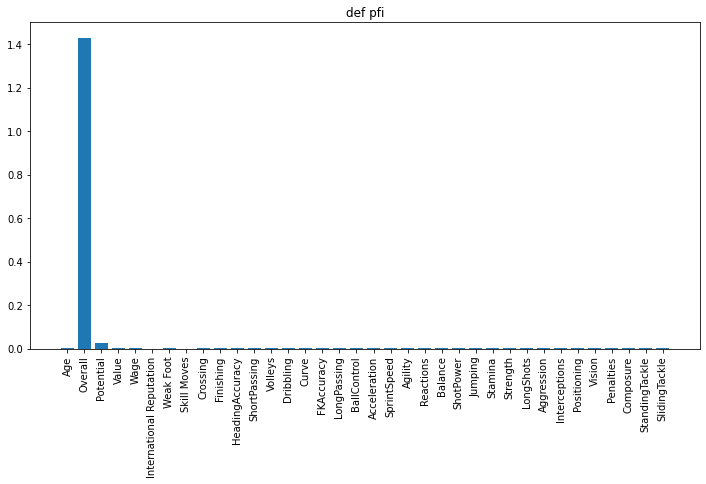

In [101]:
plot_bar_chart(def_pfi , "def pfi")

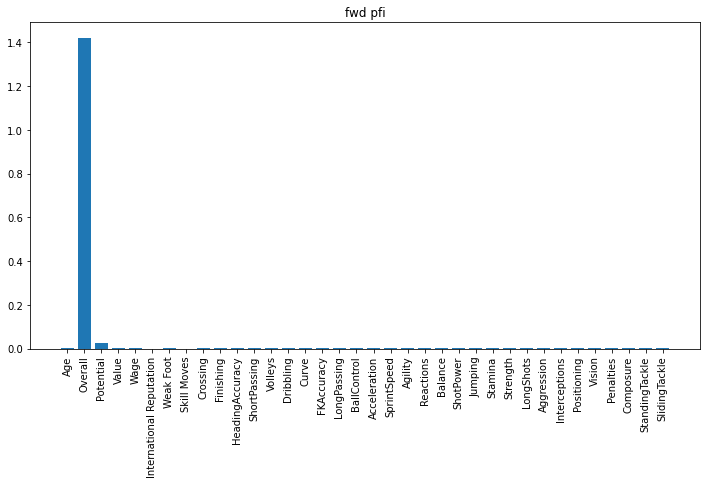

In [102]:
plot_bar_chart(fwd_pfi, "fwd pfi")

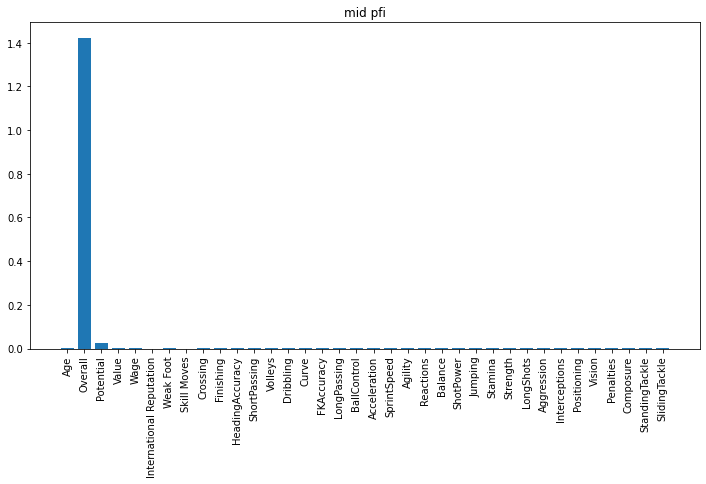

In [103]:
plot_bar_chart(mid_pfi, "mid pfi")

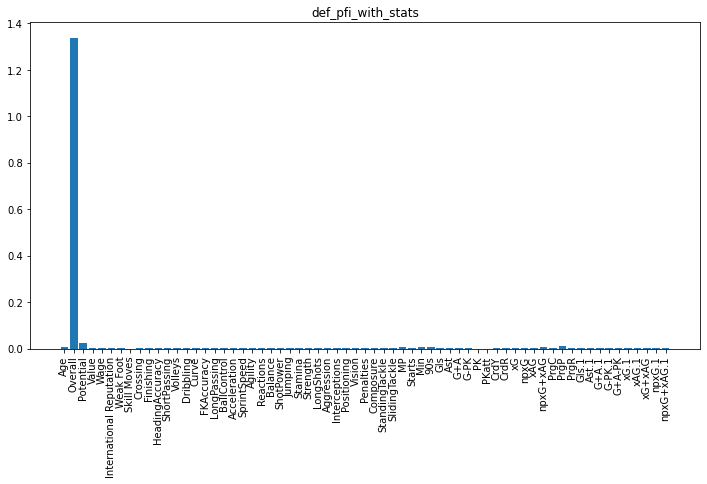

In [104]:
plot_bar_chart(def_pfi_g, "def_pfi_with_stats")

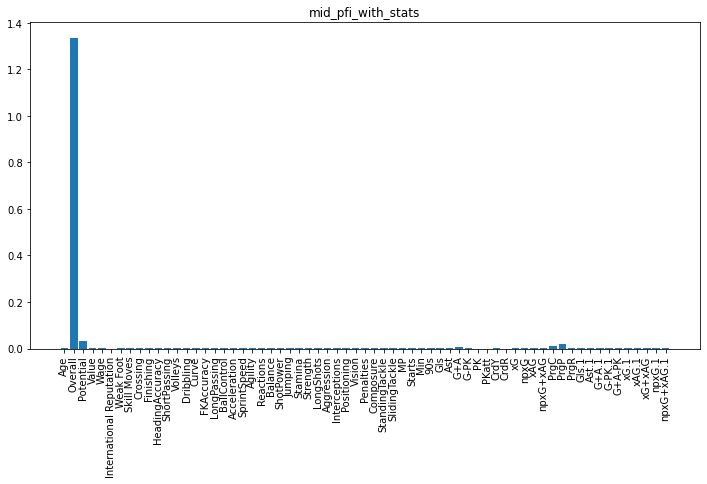

In [105]:
plot_bar_chart(mid_pfi_g, "mid_pfi_with_stats")

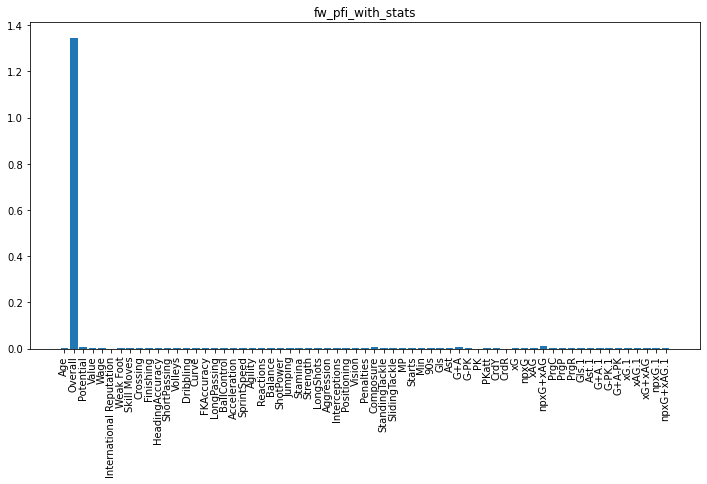

In [106]:
plot_bar_chart(fw_pfi_g, "fw_pfi_with_stats")